# Extracting multimodal data features

`siibra` provides access to data features of different modalities using the `get_features` method, which accepts a feature modality and is sensitive to the selections configured in the atlas (parcellation, region). If not particular selection is made, `get_features` considers all brain regions of the current parcellation.

In [1]:
import siibra
from os import environ

[siibra:INFO] Version: 0.2a4
[siibra:WARNING] This is a development release. Use at your own risk.
[siibra:INFO] Please file bugs and issues at https://github.com/FZJ-INM1-BDA/siibra-python.


### 1. Setup `siibra` to connect to the EBRAINS Knowledge Graph access token

`siibra` retrieves some data from the EBRAINS Knowledge Graph, which requires
authentication. To do so, please follow these steps:

 1. If you do not yet have an EBRAINS account, register [here](https://ebrains.eu/register). As you are reading this notebook in the EBRAINS collaboratory, this is most probably not necessary at this point.
 2. Your EBRAINS account needs to be enabled for programmatic access to the EBRAINS Knowledge Graph to fetch metadata. This is formal step to acknowledge additional terms of use, and done quickly by emailing to the KG team. A link and template email to do so can be found right on top of the [Knowledge Graph developer page](https://kg.humanbrainproject.eu/develop.html).
 3. Create an authentication token for EBRAINS by visiting
[the EBRAINS authorization endpoint](https://nexus-iam.humanbrainproject.org/v0/oauth2/authorize). 
 4. Copy the token, and store it in the enviroment variable `HBP_AUTH_TOKEN` (just modify and execute the cell below accordingly).

Note that as of now, you have to get a new token (steps 3. and 4.) approximately every day.

In [2]:
#token = input("Enter your token here, then press 'Enter': ")
siibra.set_ebrains_token("xxx")

[siibra:INFO] Setting EBRAINS Knowledge Graph authentication token: xxx


### 2. Extract transmitter receptor densities

Transmitter receptor density fingerprints are linked to brain regions by their name in the EBRAINS Knowledge Graph. Like any data feature, they are accessed using the `get_features` method of the atlas, which makes use of the current selection in the atlas. The `get_features` method knows from the specified data modality that the match is determined from the brain region identified. Receptor densities come as a nicely structured datatype. Amongst other things, they can visualize themselves in a plot.

If we don't specify a particular selection, the atlas will return all available receptor density features linked to the parcellation map:

In [ ]:
atlas = siibra.atlases['human']
features = siibra.get_features(
    atlas.get_parcellation('julich'),
    siibra.modalities.ReceptorDistribution)
print("Receptor density features found for the following regions:")
print(", ".join({f.regionspec for f in features}))

If we select a region, the returned list is filtered accordingly. 

In [ ]:
for r in siibra.get_features(atlas.get_region('v1'),'receptor'):
    fig = r.plot(r.regionspec)

### 3. Cell distributions

This version of siibra provides a pre-release preview of layer-specific cell distributions in different areas of BigBrain.

[siibra:INFO] Multiple elements matched the specification 'julich' - the first in order was chosen: Julich-Brain Cytoarchitectonic Maps 2.9
[siibra:WARNING] PREVIEW DATA! CorticalCellDistribution data is only a pre-release snapshot. Contact support@ebrains.eu if you intend to use this data.


Plotting only 2 of 10 features.


[siibra:INFO] A NeuroglancerMesh object was registered, but this type is not yet explicitly supported.


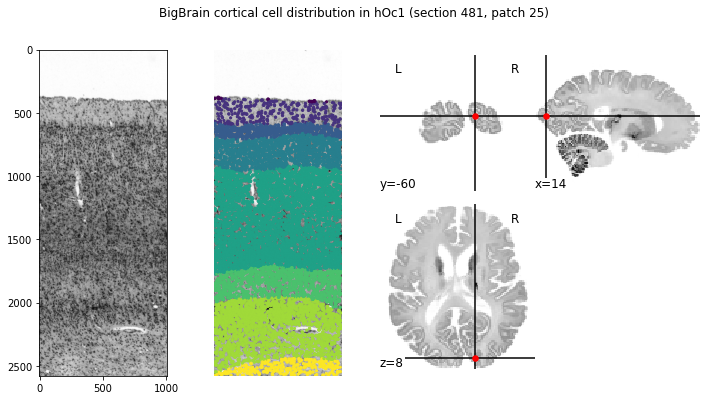

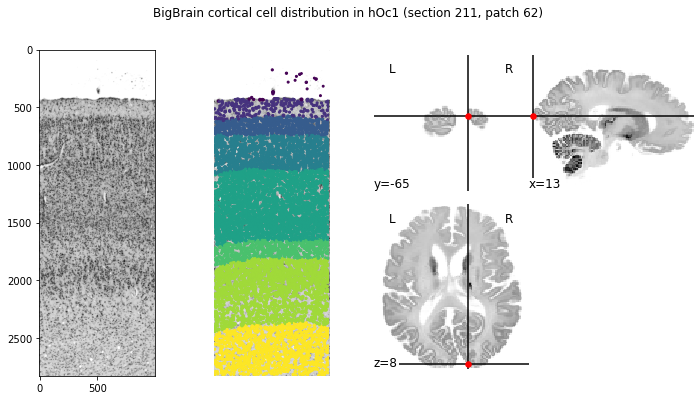

In [3]:
atlas = siibra.atlases['human']
features = siibra.get_features(
    atlas.get_region('V1','julich'),
    siibra.modalities.CorticalCellDistribution)

N = 2
if N<len(features):
    print(f"Plotting only {N} of {len(features)} features.")
for f in features[:N]:
    fig = f.plot(f.regionspec)


### 4. Extracting Gene Expressions from the Allen Atlas 

The atlas client can make calls to gene expression data from the Allen atlas and evaluate them in the ICBM space to find regional gene expression levels. It also has a list of available gene names for convenient selection. Gene expressions are linked to atlas regions by coordinates of their probes in MNI space. The `get_features` method detects this from the feature modality, and applies the mask of the regions that are currently selected in the atlas to filter the probes. We can visualize these filtered locations.

In [ ]:
region = atlas.get_region("V1")
features = siibra.get_features(
    region, "gene expression", 
    gene=siibra.features.gene_names.GABARAPL2)
print(features[0])

# Since gene expressions are spatial features,
# let's check the reference space of the results.
space =features[0].space
assert(all(f.space==space for f in features))

# plot
from nilearn import plotting
all_coords = [tuple(g.location) for g in features]
mask = region.build_mask(space)
display = plotting.plot_roi(mask)
display.add_markers(all_coords,marker_size=5) 

### 5. Retrieving connectivity matrices
For `siibra`, a connectivity matrix is a data feature like the others below, and can be found using the same `get_features` function just by choosing another modality. `siibra` knows from the modality type that this type of data does not match to the selected brain region in the atlas, but to the selected parcellation. Therefore, `get_features` return connectivity datasets that are defined for the selected parcellation. 

To learn about the nature of the provided connectivity, the `src_info` attribute provides a detailed description of the dataset. 

In [ ]:
# Get connectivity matrices available for a parcellation
features = siibra.get_features(
    atlas.get_parcellation(),
    siibra.modalities.ConnectivityMatrix)

# format dataset names for use as figure titles
from textwrap import wrap
titleformat = lambda text : "\n".join(wrap(text.replace('_',' '),20)) 

# plot the matrices
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure()
for i,feature in enumerate(features):
    ax = fig.add_subplot(1,len(features),i+1)
    ax.imshow(np.log(feature.array),cmap=plt.cm.hot)
    ax.set_title(titleformat(feature.name),size=10)
fig.show()

### 6. Retrieving iEEG electrodes and contact points

iEEG data is queried per session/subject. The data is organized into multiple electrodes per session, and multiple contact points per electrode. Iterating over a session yields its electrodes. Iterating over each electrode yields its contact points. Each of these items are themselves of type `SpatialFeature`, so they have a `.location` and can be matched against an atlas. Below, we use this to visualize MNI coordinates of contact points which correspond to electrodes touching the selected region. We highlight the contact points inside the selected atlas region in red.

In [ ]:
region = atlas.get_region('V1 right')
sessions = siibra.get_features(region, siibra.modalities.IEEG_Session)

contactpoints = [contactpoint
          for session in sessions
          for electrode in session
          for contactpoint in electrode
          if electrode.matches(region)]
coords = [
    tuple(cp.location) 
    for cp in contactpoints]
colors = [
    "red" if cp.matches(region) else "gray" 
    for cp in contactpoints]

from nilearn import plotting
plotting.view_markers(coords,colors,marker_size=3)

### 7. Retrieving other types of regional datasets from EBRAINS

In [ ]:
region = atlas.get_region("fp1 right")
for f in siibra.get_features(region, "ebrains"):
    print(f"{f.name}\n{f.url}\n")